C:\Users\boett\AppData\Local\Temp\ipykernel_59104\618617486.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_year'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()
C:\Users\boett\AppData\Local\Temp\ipykernel_59104\618617486.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['commit_type'] = df['commit_type'].str.lower()
C:\Users\boett\AppData\Local\Temp\ipykernel_59104\618617486.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be r

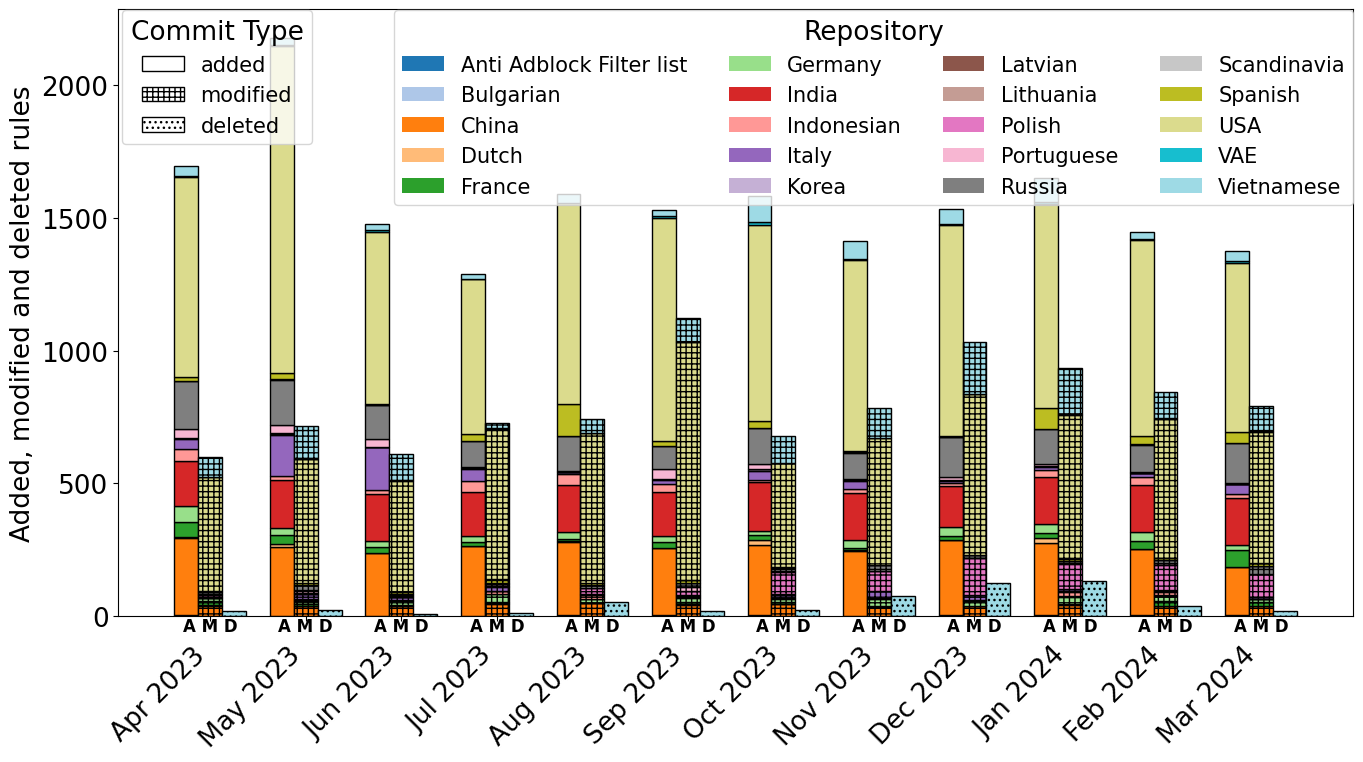

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr
from matplotlib.patches import Patch
from google.cloud import bigquery


def map_names(name):
    names = {
        "abpvn": "Vietnamese",
        "adblock-latvian": "Latvian",
        "adblockbg": "Bulgarian",
        "adfilt": "Scandinavia",
        "antiadblockfilters": "Anti Adblock Filter list",
        "easylist": "USA",
        "easylistchina": "China",
        "easylistczechandslovak": "Czech and Slovak",
        "easylistdutch": "Dutch",
        "easylistgermany": "Germany",
        "EasyListHebrew": "Israel",
        "easylistitaly": "Italy",
        "easylistpolish": "Polish",
        "easylistportuguese": "Portuguese",
        "easylistspanish": "Spanish",
        "easylist_lithuania": "Lithuania",
        "IndianList": "India",
        "indonesianadblockrules": "Indonesian",
        "KoreanList": "Korea",
        "listear": "VAE",
        "listefr": "France",
        "ruadlist": "Russia",
        "filter": "Japan"
    }
    return names.get(name, name)



def split_on_commit(text):
    # Split the text on the word "commit" and keep the "commit" in each block
    blocks = text.split("new_commit")

    # Reattach the "commit" to the beginning of each block (skip the first split part if it's empty)
    blocks = [("commit" + block).strip() for block in blocks if block.strip()]

    return blocks




def create_stacked_bar(df):
    plt.rcParams.update({'font.size': 19})

    # Apply the 'map_names' function to 'repository' column
    df['repository'] = df['repository'].apply(map_names)

    # Ensure 'timestamp' is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ensure 'additions' and 'deletions' are numeric
    df['additions'] = pd.to_numeric(df['additions'], errors='coerce').fillna(0)
    df['deletions'] = pd.to_numeric(df['deletions'], errors='coerce').fillna(0)

    # Filter data from 2022 onwards to 4.2024
    df = df[(df['timestamp'] >= "2023-04-01") & (df['timestamp'] < "2024-04-01")]

    # Extract month and year for grouping
    df['month_year'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()

    # Filter only 'added', 'modified', 'deleted' commit types (case-insensitive)
    df['commit_type'] = df['commit_type'].str.lower()
    df_filtered = df[df['commit_type'].isin(['added', 'modified', 'deleted'])]

    # Check if df_filtered is empty
    if df_filtered.empty:
        print("No data available for the specified commit types and date range.")
        return

    # Group by 'month_year', 'commit_type', 'repository' and count the occurrences
    counts_df = df_filtered.groupby(['month_year', 'commit_type', 'repository']).size().reset_index(name='count')

    # Get the unique months, commit types, and repositories
    months = sorted(counts_df['month_year'].unique())
    commit_types = ['added', 'modified', 'deleted']  # The order as per your request
    repositories = sorted(counts_df['repository'].unique())

    N = len(months)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))

    # Colors for the repositories (cycling through colors)
    colors = plt.cm.get_cmap('tab20', len(repositories)).colors

    # Hatch patterns for commit types
    hatch_patterns = {
        'added': '  ',
        'modified': '+++',
        'deleted': '...'
    }

    # Initialize lists for legends
    repo_handles = []
    repo_labels = []
    commit_type_handles = []
    commit_type_labels = []

    for i, commit_type in enumerate(commit_types):
        # Initialize bottom to zero for stacking
        bottoms = np.zeros(N)
        # Get data for the specific commit_type
        dfs = counts_df[counts_df['commit_type'] == commit_type]
        # Pivot to get repositories as columns
        dfs = dfs.pivot(index='month_year', columns='repository', values='count').fillna(0)
        # Reindex to ensure all months and repositories are included
        dfs = dfs.reindex(index=months, columns=repositories, fill_value=0)
        for j, repository in enumerate(repositories):
            counts = dfs[repository].values.astype(float)
            # Plot the bar with hatch patterns and edge colors
            bars = ax.bar(ind + i * width, counts, width, bottom=bottoms,
                          color=colors[j % len(colors)],
                          hatch=hatch_patterns[commit_type],
                          edgecolor='black')
         

            # Update the bottom for stacking
            bottoms += counts

            # Add repository to legend once
            if i == 0:
                repo_handles.append(Patch(facecolor=colors[j % len(colors)], label=repository))
                repo_labels.append(repository)
        # Add commit type to legend once
        commit_type_handles.append(Patch(facecolor='white', edgecolor='black',
                                         hatch=hatch_patterns[commit_type], label=commit_type))
        commit_type_labels.append(commit_type)

    for i, month in enumerate(months):
            # Calculate the center of the bar group
            x_pos = ind[i] + width  # Center position for each bar group
            # Place the labels below the bars and above the x-axis labels
            ax.text(x_pos, -36, 'A M D', ha='center', va='center', fontsize=12, fontweight='bold', color='black',
                    transform=ax.transData)
            
    # Set labels and title
    ax.set_xticks(ind + width)
    ax.set_xticklabels([m.strftime('%b %Y') for m in months], rotation=45, ha="right")
    ax.set_ylabel('Added, modified and deleted rules')
    ax.tick_params(axis='x', pad=15)  # Increase padding between tick labels and axis
    #ax.set_title('Commit Types per Month (Stacked by Repository)')

    # Create legends
    # Repository legend (colors)
    repo_legend = ax.legend(handles=repo_handles, title='Repository',ncol=4, bbox_to_anchor=(0.215, 1.015), loc='upper left', fontsize=15)
    # Commit type legend (hatch patterns)
    commit_type_legend = ax.legend(handles=commit_type_handles, title='Commit Type',bbox_to_anchor=(0.08, 1.015), loc='upper center', fontsize=15) #,
    # Add the repository legend back
    ax.add_artist(repo_legend)

    plt.tight_layout()
    plt.show()

def get_commit_type(message):
    message = message.strip()
    if message.startswith('A:'):
        return 'Added'
    elif message.startswith('D:'):
        return 'Deleted'
    elif message.startswith('M:'):
        return 'Modified'
    elif message.startswith('Auto build'):
        return 'Auto build update'
    else:
        return 'Unknown'



if __name__ == "__main__":
    path = "D:/filterlisten - githubs/"

    dir = os.listdir(path)

    folders = [d for d in dir if os.path.isdir(os.path.join(path, d))]

    d = list()
    for folder in folders:
        output_file_path = os.path.join(path, folder, 'output_all.txt')
        with open(output_file_path, 'r', encoding='utf8') as f:
            data = f.read()

        # Split the text
        commit_blocks = split_on_commit(data)

        for i, block in enumerate(commit_blocks, 1):

            try:
                commit, date, message,file, additions, deletions, author = block.splitlines()
            except:
                print(block)
                exit()

            data_row = {
                'repository': folder,
                'file': file.replace('file changed:', ''),
                'commit_sha': commit.replace('commit:', ''),
                'message': message.replace('message:', ''),
                'commit_type': get_commit_type(message.replace('message:', '')),
                'timestamp': date.replace('date:', ''),
                'author': author.replace('author:', ''),
                'additions': additions.replace('number_of_adds:', ''),
                'deletions': deletions.replace('number_of_removes:', '')
            }

            d.append(data_row)


    df = pd.DataFrame.from_records(d)

    create_stacked_bar(df)
